# `AVDOS-VR` - Virtual Reality Affective Video Database with Physiological Signals

Notebook containing the postprocessing stages for the AVDOSVR dataset.

It transforms individual files containing events (.json) and physiological responses (.csv) per each participant, and produces a single file `Dataset_AVDOSVR_full_postprocessed.csv` synchronizing physiological responses, affect ratings, and grouped per affect segment and experimental stages (rest, video).

In [1]:
# Add files to sys.path
from pathlib import Path
import sys,os
this_path = None
try:    # WORKS WITH .py
    this_path = str(os.path.dirname(os.path.abspath(__file__)))
except: # WORKS WITH .ipynb
    this_path = str(Path().absolute())+"/" 
print("File Path:", this_path)

# Add the level up to the file path so it recognizes the scripts inside `avdosvr`
sys.path.append(os.path.join(this_path, ".."))

File Path: e:\dsv\dev\git_repos\AVDOS-VR\notebooks/


In [2]:
# Import classes
import avdosvr.preprocessing       # Generate dataset index, load files, and plots.

# Shortcut for general variable constants
import avdosvr.utils.enums as avdosEnums
# Utils for generation of files and paths
from avdosvr.utils import files_handler
from avdosvr.analysis.dataframe_functions import resample_dataframe

# Import data science libs
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
#matplotlib.rcParams['text.usetex'] = True

---
## Setup

Global variables and functions for file management

In [3]:
### General configuration

# Path to the participants' folder w.r.t this notebook's filepath
DATASET_ROOT_FOLDER = "../data/"

# Used to generate the path of temporary subfolders
NOTEBOOK_NAME = "1_preprocess"

In [4]:
# Functions to generate filepaths

# MAIN FOLDERS FOR OUTPUT FILES
ROOT = this_path + ""   # Root folder for all the files w.r.t this file
TEMP_FOLDER = ROOT+"temp/"  # Main folder for temp files with intermediate calculations
RESULTS_FOLDER = ROOT+"results/"    # Folder to recreate plots and results from analyses

# Generates paths for files created from this script
def gen_path_temp(filename, extension, subfolders=""):
    # Generates full paths for TEMP FILES just by specifying a name
    return files_handler.generate_complete_path(filename, \
                                        main_folder=TEMP_FOLDER, \
                                        subfolders=NOTEBOOK_NAME+"/"+subfolders, \
                                        file_extension=extension)


---
## Creating a dataset index

The class `avdosvr.processing.Manager()` contains the scripts to generate an index of the dataset, which facilitates access to the data per participant, event, experimental segment, or physiological variable.

In [5]:
# The preprocessing manager analyzes the original data folder
# to create an index and facilitate preprocessing.
data_loader = avdosvr.preprocessing.Manager(DATASET_ROOT_FOLDER, 
                                    index_files_path = TEMP_FOLDER, # None,
                                    force_index_regeneration=True, 
                                    verbose = True,
                                    )

Forcing index construction!! e:\dsv\dev\git_repos\AVDOS-VR\notebooks/temp/avdosvr_index/avdosvr_tree_index.json

Directory >> participant_101
	 Data>> video_1
	 Event>> video_1
	 Data>> video_2
	 Event>> video_2
	 Data>> video_3
	 Event>> video_3
	 Data>> video_4
	 Event>> video_4
	 Data>> video_5
	 Event>> video_5
	 Events compiled in e:\dsv\dev\git_repos\AVDOS-VR\notebooks/temp/avdosvr_index/participant_101\compiled_emotion_ratings.csv

Directory >> participant_216
	 Data>> video_1
	 Event>> video_1
	 Data>> video_2
	 Event>> video_2
	 Data>> video_3
	 Event>> video_3
	 Data>> video_4
	 Event>> video_4
	 Data>> video_5
	 Event>> video_5
	 Events compiled in e:\dsv\dev\git_repos\AVDOS-VR\notebooks/temp/avdosvr_index/participant_216\compiled_emotion_ratings.csv

Directory >> participant_219
	 Data>> video_1
	 Event>> video_1
	 Data>> video_2
	 Event>> video_2
	 Data>> video_3
	 Event>> video_3
	 Data>> video_4
	 Event>> video_4
	 Data>> video_5
	 Event>> video_5
	 Events compiled in e:

The summary dataframe produces the following columns:
- `index_id`: Identifier of a participant in the index, based on the order of the folders in the original dataset.
- `participant_id`: Participant's identifier according to original folder name.
- `protocol`: *v1* or *v2* depending on which type of remote experiment the participant did (see paper for details).
- `Segment`: *video_1* to *video_5* identifying the filename of the experimental segment.
- `NonAffectiveEvents_N`: Number of events **not** related to self-reported affective ratings.
- `NonAffectiveEvents_duration`: The difference between the first and the last non affective event (in seconds).
- `AffectiveRatings_N`: Number of events related to self-reported affective ratings.
- `AffectiveRatings_duration`: The difference between the first and the last affective event (in seconds). (No ratings as *NaN* in the dataframe)
- `AffectiveRatings_Valence_avg`: Average *Valence* ratings throughout a specific experimental *Segment*.
- `AffectiveRatings_Arousal_avg`: Average *Arousal* ratings throughout a specific experimental *Segment*.

In [6]:
# The attribute `summary` presents an overview on the original files.
# Note that it does not consider synchronization with the 
# real events in the experiment
data_loader.summary

,index_id,participant_id,protocol,Segment,NonAffectiveEvents_N,NonAffectiveEvents_duration,AffectiveRatings_N,AffectiveRatings_duration,AffectiveRatings_Valence_avg,AffectiveRatings_Arousal_avg
0,0,101,v1,video_1,76,175.555,1,0.000,3.000000,5.000000
1,0,101,v1,video_2,30,420.134,164,415.966,6.390244,5.737805
2,0,101,v1,video_3,26,420.161,121,416.545,2.677686,5.933884
3,0,101,v1,video_4,26,420.217,131,406.863,5.618321,4.862595
4,0,101,v1,video_5,4,120.121,15,101.889,3.733333,1.000000
...,...,...,...,...,...,...,...,...,...,...
190,38,384,v1,video_1,28,170.901,3,0.928,3.333333,6.333333
191,38,384,v1,video_2,26,420.101,265,420.711,4.033962,4.550943
192,38,384,v1,video_3,26,420.024,330,417.415,3.154545,4.884848
193,38,384,v1,video_4,30,420.069,336,420.292,5.800595,5.488095


In [7]:
# Some rows contain no data, but they are in the resting video_1
data_loader.summary[ data_loader.summary.isna().any(axis=1) ]

,index_id,participant_id,protocol,Segment,NonAffectiveEvents_N,NonAffectiveEvents_duration,AffectiveRatings_N,AffectiveRatings_duration,AffectiveRatings_Valence_avg,AffectiveRatings_Arousal_avg
20,4,247,v1,video_1,39,267.907,0,NaN,NaN,NaN
25,5,248,v1,video_1,39,358.829,0,NaN,NaN,NaN
35,7,270,v1,video_1,25,371.664,0,NaN,NaN,NaN
40,8,278,v1,video_1,45,245.235,0,NaN,NaN,NaN
70,14,309,v1,video_1,43,255.330,0,NaN,NaN,NaN
125,25,349,v2,video_1,23,194.650,0,NaN,NaN,NaN


In [8]:
# The attribute `index` contains the filepath for each
# of the events and physiological data for the participant
# with index 0. The index is according to the order how
# the files are found in the main folder `data/`
data_loader.index[0]

{'participant_id': '101',
 'protocol': 'v1',
 'events': 'e:\\dsv\\dev\\git_repos\\AVDOS-VR\\notebooks/temp/avdosvr_index/participant_101\\compiled_experimental_events.csv',
 'segments': 'e:\\dsv\\dev\\git_repos\\AVDOS-VR\\notebooks/temp/avdosvr_index/participant_101\\compiled_protocol_segment.csv',
 'emotions': 'e:\\dsv\\dev\\git_repos\\AVDOS-VR\\notebooks/temp/avdosvr_index/participant_101\\compiled_emotion_ratings.csv',
 'data': {'video_1': '../data/participant_101\\video_1.csv',
  'video_2': '../data/participant_101\\video_2.csv',
  'video_3': '../data/participant_101\\video_3.csv',
  'video_4': '../data/participant_101\\video_4.csv',
  'video_5': '../data/participant_101\\video_5.csv'}}

In [9]:
# The attribute `events` contains all events
# not related to affective states
data_loader.events[0]

,Session,Event
Time,,
1.623248e+09,video_1,Start of signal check. Started data recording....
1.623248e+09,video_1,Signal check finished. Fit state: VeryGood val...
1.623248e+09,video_1,Cinema scene started
1.623248e+09,video_1,Finger lifted
1.623248e+09,video_1,Finger back on touchpad
...,...,...
1.623249e+09,video_4,Video category finished
1.623249e+09,video_5,Playing rest video
1.623249e+09,video_5,Finished playing rest video


In [10]:
# The attribute `emotions` contains the events
# related to self-reported affective ratings.
# The RawX and RawY correspond to the original
# values measured with the joystick controller
data_loader.emotions[0]

,Session,Valence,Arousal,RawX,RawY
Time,,,,,
1.623248e+09,video_1,3,5,94,124
1.623248e+09,video_2,5,5,128,122
1.623248e+09,video_2,6,5,149,127
1.623248e+09,video_2,7,5,170,127
1.623248e+09,video_2,8,5,193,126
...,...,...,...,...,...
1.623249e+09,video_5,5,1,129,7
1.623249e+09,video_5,4,1,127,9
1.623249e+09,video_5,5,1,128,9


In [11]:
# The attribute `segments` is a subset of the data stored in
# `events`. This one contains the start and ending point
# of each of the experimental segments, and the specific VideoId
# shown during that experimental segment.
data_loader.segments[0]

,Session,Segment,VideoId,Trigger
Time,,,,
1.623248e+09,video_2,Positive,NaN,StartSegment
1.623248e+09,video_2,Positive,-1.0,Start
1.623248e+09,video_2,Positive,-1.0,End
1.623248e+09,video_2,Positive,51.0,Start
1.623248e+09,video_2,Positive,49.0,Start
...,...,...,...,...
1.623249e+09,video_4,Neutral,NaN,EndSegment
1.623249e+09,video_5,video_5,NaN,StartSegment
1.623249e+09,video_5,video_5,-1.0,Start


## Loading physiological data

Below, we show how to access and visualize specific physiological data from the files.

Note that the variable names to indicate the facial EMG are based on the placement provided by the Emteq sensor, as shown below:

![EmteqMaskSensors](https://www.frontiersin.org/files/Articles/781218/frvir-03-781218-HTML-r2/image_m/frvir-03-781218-g005.jpg)
*Image taken from paper: emteqPRO—Fully Integrated Biometric Sensing Array for Non-Invasive Biomedical Research in Virtual Reality [DOI](https://doi.org/10.3389/frvir.2022.781218))*

In [12]:
# Loading all variables for a specific participant and a specific session segment
PARTICIPANT_IDX = 0
SESSION_SEGMENT_NAME = str(avdosEnums.SessionSegment.video1) # Or you can type directly the string from session segment `video_1`

# Obtain dataframes with data and metadata
data, metadata = data_loader.load_data_from_participant(participant_idx = PARTICIPANT_IDX,
                                                        session_segment=SESSION_SEGMENT_NAME)

Loading from:  ../data/../data/participant_101\video_1.csv


In [13]:
data

,Frame,Faceplate/FaceState,Faceplate/FitState,Emg/ContactStates[RightFrontalis],Emg/Contact[RightFrontalis],Emg/Raw[RightFrontalis],Emg/RawLift[RightFrontalis],Emg/Filtered[RightFrontalis],Emg/Amplitude[RightFrontalis],Emg/ContactStates[RightZygomaticus],...,Accelerometer/Raw.x,Accelerometer/Raw.y,Accelerometer/Raw.z,Magnetometer/Raw.x,Magnetometer/Raw.y,Magnetometer/Raw.z,Gyroscope/Raw.x,Gyroscope/Raw.y,Gyroscope/Raw.z,Pressure/Raw
Time,,,,,,,,,,,,,,,,,,,,,
1.623248e+09,1,1,9,255,1833,393708,0,563,1450,255,...,874,31,-417,-485,-336,805,-151,20,16,0
1.623248e+09,2,1,5,255,1833,393708,0,-754,1450,0,...,874,31,-417,-485,-336,805,-151,20,16,0
1.623248e+09,3,1,5,255,1833,393708,0,1650,1450,0,...,874,31,-417,-485,-336,805,-151,20,16,0
1.623248e+09,4,1,5,255,1833,393708,0,-634,1450,0,...,874,31,-417,-485,-336,805,-151,20,16,0
1.623248e+09,5,1,5,255,1833,393708,0,1343,1450,0,...,874,31,-417,-485,-336,805,-151,20,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.623248e+09,171797,1,9,255,2906,413625,0,-38,27,255,...,866,-3,-428,-485,-360,780,-30,90,-21,0
1.623248e+09,171798,1,9,255,2906,413781,0,-72,27,255,...,872,-1,-430,-485,-360,780,-29,119,-2,0
1.623248e+09,171799,1,9,255,2887,413781,0,25,27,255,...,872,-1,-430,-485,-360,780,-29,119,-2,0


In [14]:
metadata

,metadata,value,more
0,#Format/Version,CSV1.1.0,NaN
1,#File/Normalised,NO,NaN
2,#File/Generator,dab2csv,v0.7.0-60-ga2621eb
3,#File/Source,E:\emteq-data-science\VR\python\data_preproces...,NaN
4,#Protocol/Version,MASK.1.2,NaN
5,#Firmware/Build.buildTag,v0.4.4-0-g2e9aa13,NaN
6,#Device/Version.serialId,DAB006G+TM5OVMgICA4FEQQ/w,NaN
7,#Device/Version.hardware,9.3.6-Mobile,NaN
8,#Protocol/Log.message,AT21CS01 DeviceAddress=0,NaN
9,#Faceplate/Version.serial,FLXoHHLagAAgdw,NaN


In [15]:
data.describe()

,Frame,Faceplate/FaceState,Faceplate/FitState,Emg/ContactStates[RightFrontalis],Emg/Contact[RightFrontalis],Emg/Raw[RightFrontalis],Emg/RawLift[RightFrontalis],Emg/Filtered[RightFrontalis],Emg/Amplitude[RightFrontalis],Emg/ContactStates[RightZygomaticus],...,Accelerometer/Raw.x,Accelerometer/Raw.y,Accelerometer/Raw.z,Magnetometer/Raw.x,Magnetometer/Raw.y,Magnetometer/Raw.z,Gyroscope/Raw.x,Gyroscope/Raw.y,Gyroscope/Raw.z,Pressure/Raw
count,171801.000000,171801.0,171801.000000,171801.0,171801.000000,171801.000000,171801.0,171801.000000,171801.000000,171801.000000,...,171801.000000,171801.000000,171801.000000,171801.000000,171801.000000,171801.000000,171801.000000,171801.000000,171801.000000,171801.0
mean,85901.000000,1.0,8.998696,255.0,2896.242484,398041.483461,0.0,0.009470,27.693209,254.847614,...,858.715403,30.573111,-449.404061,-468.533751,-369.345452,808.338066,-2.684082,-1.890746,1.250988,0.0
std,49594.821136,0.0,0.057078,0.0,27.037809,6482.151936,0.0,33.023236,38.315856,5.694696,...,22.521608,13.885057,36.770500,26.997449,19.989697,28.929391,135.773231,133.427634,78.365709,0.0
min,1.000000,1.0,5.000000,255.0,1654.000000,388447.000000,0.0,-1310.000000,17.000000,0.000000,...,726.000000,-55.000000,-559.000000,-580.000000,-444.000000,671.000000,-1831.000000,-1164.000000,-734.000000,0.0
25%,42951.000000,1.0,9.000000,255.0,2889.000000,392935.000000,0.0,-17.000000,23.000000,255.000000,...,845.000000,23.000000,-476.000000,-485.000000,-384.000000,792.000000,-18.000000,-28.000000,-12.000000,0.0
50%,85901.000000,1.0,9.000000,255.0,2896.000000,396066.000000,0.0,0.000000,25.000000,255.000000,...,856.000000,33.000000,-457.000000,-461.000000,-372.000000,813.000000,-1.000000,-2.000000,1.000000,0.0
75%,128851.000000,1.0,9.000000,255.0,2903.000000,404846.000000,0.0,17.000000,27.000000,255.000000,...,871.000000,40.000000,-429.000000,-449.000000,-354.000000,826.000000,17.000000,20.000000,11.000000,0.0
max,171801.000000,1.0,9.000000,255.0,3023.000000,413896.000000,0.0,1650.000000,1480.000000,255.000000,...,1088.000000,95.000000,-273.000000,-389.000000,-294.000000,886.000000,1161.000000,1942.000000,1381.000000,0.0


### Normalization

The command above allows loading the raw data as it is from the file. The only normalization is the `Time` to unix timestamps, so that it maps the timestamps from the event files.

The attribute `normalize_data_units` allows loading the data with normalized units, as follows:
- The EMG variables with type `Raw/`, `Filtered/`, and `Amplitude/` are normalized with the value in `#Emg/Properties.rawToVoltageDivisor` to produce signal in **volts**.
- The EMG variables with type `Contact/` are normalized with the value in `#Emg/Properties.contactToImpedanceDivisor` to produce data in **ohms**.
- The `Accelerometer/` variables are normalized with `#Accelerometer/Properties.rawDivisor` to produce data in $m/s^2$.
- The `Magnetometer/` variables are normalized with `#Magnetometer/Properties.rawDivisor` to produce data in $\mu$ Tesla.
- The `Gyroscope/` variables are normalized with `#Gyroscope/Properties.rawDivisor` to produce data in $^\circ/s$.

In [16]:
# Obtain normalized data with parameter `normalize_data_units`
data, metadata = data_loader.load_data_from_participant(participant_idx = PARTICIPANT_IDX,
                                                        session_segment=SESSION_SEGMENT_NAME,
                                                        normalize_data_units=True)

Loading from:  ../data/../data/participant_101\video_1.csv


In [17]:
# Note how the range of the values changed to the correct units
# compared  to the non-normalize data
data.describe()

,Frame,Faceplate/FaceState,Faceplate/FitState,Emg/ContactStates[RightFrontalis],Emg/Contact[RightFrontalis],Emg/Raw[RightFrontalis],Emg/RawLift[RightFrontalis],Emg/Filtered[RightFrontalis],Emg/Amplitude[RightFrontalis],Emg/ContactStates[RightZygomaticus],...,Accelerometer/Raw.x,Accelerometer/Raw.y,Accelerometer/Raw.z,Magnetometer/Raw.x,Magnetometer/Raw.y,Magnetometer/Raw.z,Gyroscope/Raw.x,Gyroscope/Raw.y,Gyroscope/Raw.z,Pressure/Raw
count,171801.000000,171801.0,171801.000000,171801.0,171801.000000,171801.000000,171801.0,1.718010e+05,1.718010e+05,171801.000000,...,171801.000000,171801.000000,171801.000000,171801.000000,171801.000000,171801.000000,171801.000000,171801.000000,171801.000000,171801.0
mean,85901.000000,1.0,8.998696,255.0,5792.484968,0.015817,0.0,3.763143e-10,1.100429e-06,254.847614,...,8.587154,0.305731,-4.494041,-29.283359,-23.084091,50.521129,-0.167755,-0.118172,0.078187,0.0
std,49594.821136,0.0,0.057078,0.0,54.075617,0.000258,0.0,1.312226e-06,1.522535e-06,5.694696,...,0.225216,0.138851,0.367705,1.687341,1.249356,1.808087,8.485827,8.339227,4.897857,0.0
min,1.000000,1.0,5.000000,255.0,3308.000000,0.015435,0.0,-5.205472e-05,6.755193e-07,0.000000,...,7.260000,-0.550000,-5.590000,-36.250000,-27.750000,41.937500,-114.437500,-72.750000,-45.875000,0.0
25%,42951.000000,1.0,9.000000,255.0,5778.000000,0.015614,0.0,-6.755193e-07,9.139379e-07,255.000000,...,8.450000,0.230000,-4.760000,-30.312500,-24.000000,49.500000,-1.125000,-1.750000,-0.750000,0.0
50%,85901.000000,1.0,9.000000,255.0,5792.000000,0.015738,0.0,0.000000e+00,9.934107e-07,255.000000,...,8.560000,0.330000,-4.570000,-28.812500,-23.250000,50.812500,-0.062500,-0.125000,0.062500,0.0
75%,128851.000000,1.0,9.000000,255.0,5806.000000,0.016087,0.0,6.755193e-07,1.072884e-06,255.000000,...,8.710000,0.400000,-4.290000,-28.062500,-22.125000,51.625000,1.062500,1.250000,0.687500,0.0
max,171801.000000,1.0,9.000000,255.0,6046.000000,0.016447,0.0,6.556511e-05,5.880992e-05,255.000000,...,10.880000,0.950000,-2.730000,-24.312500,-18.375000,55.375000,72.562500,121.375000,86.312500,0.0


### Selecting subsets of physiological variables

The parameter `columns` allows loading a certain subset of variables from the physiological signal. Especially because there is redundancy in the EMG variables `Raw/`, `Filtered/`, and `Amplitude`.

To make it easier to access subset of variables, we show below how to access a specific data channels from the configuration file:

- Physical faceplate: `COLNAMES_FACEPLATE`,
- Facial EMG: `COLNAMES_EMG_RAW`, `COLNAMES_EMG_FILTERED`, `COLNAMES_EMG_AMPLITUDE`, 
- Contact states: `COLNAMES_EMG_CONTACT`, `COLNAMES_EMG_CONTACT_STATES`, `COLNAMES_NON_EMG_BASIC`
- Heart-related: `COLNAMES_HR`, `COLNAMES_PPG`
- Movement-related: `COLNAMES_ACCELEROMETER`, `COLNAMES_MAGNETOMETER`, `COLNAMES_GYROSCOPE`

The variable `COLNAMES_RECOMMENDED` contains a suggested set of columns useful for analysis, but you can always select columns by providing a list with the custom names that you would like to load.

The function `avdosvr.preprocessing.GetColnamesFromEmgMuscle()` allows to access all variables for a specific muscle type.

In [18]:
# For example: Creating a list of columns to extract all variables from center corrugator,
# the amplitude of all sensors, heart rate, and pressur.
COLS_OF_INTEREST = avdosvr.preprocessing.GetColnamesFromEmgMuscle(avdosEnums.EmgMuscles.CenterCorrugator) +\
                avdosvr.preprocessing.COLNAMES_EMG_AMPLITUDE +\
                avdosvr.preprocessing.COLNAMES_HR
print(COLS_OF_INTEREST)

['Emg/ContactStates[CenterCorrugator]', 'Emg/Contact[CenterCorrugator]', 'Emg/Raw[CenterCorrugator]', 'Emg/RawLift[CenterCorrugator]', 'Emg/Filtered[CenterCorrugator]', 'Emg/Amplitude[CenterCorrugator]', 'Emg/Amplitude[RightFrontalis]', 'Emg/Amplitude[RightZygomaticus]', 'Emg/Amplitude[RightOrbicularis]', 'Emg/Amplitude[CenterCorrugator]', 'Emg/Amplitude[LeftOrbicularis]', 'Emg/Amplitude[LeftZygomaticus]', 'Emg/Amplitude[LeftFrontalis]', 'HeartRate/Average']


In [19]:
# Obtain normalized data with parameter `normalize_data_units`
data, metadata = data_loader.load_data_from_participant(participant_idx = PARTICIPANT_IDX,
                                                        session_segment=SESSION_SEGMENT_NAME,
                                                        normalize_data_units=True,
                                                        columns = COLS_OF_INTEREST)

Loading from:  ../data/../data/participant_101\video_1.csv


In [20]:
data.columns

Index(['Emg/ContactStates[CenterCorrugator]', 'Emg/Contact[CenterCorrugator]',
       'Emg/Raw[CenterCorrugator]', 'Emg/RawLift[CenterCorrugator]',
       'Emg/Amplitude[RightZygomaticus]', 'Emg/Amplitude[CenterCorrugator]',
       'Emg/Amplitude[RightOrbicularis]', 'HeartRate/Average',
       'Emg/Amplitude[LeftFrontalis]', 'Emg/Filtered[CenterCorrugator]',
       'Emg/Amplitude[RightFrontalis]', 'Emg/Amplitude[LeftZygomaticus]',
       'Emg/Amplitude[LeftOrbicularis]'],
      dtype='object')

## Plotting

The resulting `data` is a pandas dataframe and can be plotted as such. See their [official documentation](https://pandas.pydata.org/pandas-docs/stable/reference/plotting.html)

In [ ]:
# Visualize each channel separately
data.plot.line(figsize=(15,1*data.shape[1]), subplots=True, sharex=True)

## Iterating over all participants

It is commonly interesting to compile data from all participants. However, the resulting dataframe may be large and not fit in memory.
We suggest design a preprocessing stage for each participant that generates a smaller dataset, and then join them together for complete analysis.

In the example below, we show two examples on how to iterate over the participants' data.

In [21]:
# Total participants
participants_ids = data_loader.summary["index_id"].unique()
participants_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38], dtype=int64)

In [22]:
# Total sessions
experiment_segment_names = data_loader.summary["Segment"].unique()
experiment_segment_names

array(['video_1', 'video_2', 'video_3', 'video_4', 'video_5'],
      dtype=object)

In [23]:
# Iterate over all participants and segments
for participant in participants_ids:
    for exp_segment in experiment_segment_names:
        print(f"\t>> Participant {participant} and segment {exp_segment}")
print("\n\n=======\nFinished iterating all relevant data!") 
### It takes around 15 mins just loading all the raw dataset one by one

	>> Participant 0 and segment video_1
	>> Participant 0 and segment video_2
	>> Participant 0 and segment video_3
	>> Participant 0 and segment video_4
	>> Participant 0 and segment video_5
	>> Participant 1 and segment video_1
	>> Participant 1 and segment video_2
	>> Participant 1 and segment video_3
	>> Participant 1 and segment video_4
	>> Participant 1 and segment video_5
	>> Participant 2 and segment video_1
	>> Participant 2 and segment video_2
	>> Participant 2 and segment video_3
	>> Participant 2 and segment video_4
	>> Participant 2 and segment video_5
	>> Participant 3 and segment video_1
	>> Participant 3 and segment video_2
	>> Participant 3 and segment video_3
	>> Participant 3 and segment video_4
	>> Participant 3 and segment video_5
	>> Participant 4 and segment video_1
	>> Participant 4 and segment video_2
	>> Participant 4 and segment video_3
	>> Participant 4 and segment video_4
	>> Participant 4 and segment video_5
	>> Participant 5 and segment video_1
	>> Particip

*Uncomment the block below if you want to iterate over the whole dataset. However, the block takes around 15 mins finalizing.*

In [24]:
# ### Testing how long it would take to iterate over the whole dataset
# ### without including normalization
# import time
# for participant in participants_ids:
#     for exp_segment in experiment_segment_names:
#         t0 = time.time()
#         data, metadata = data_loader.load_data_from_participant(participant_idx = participant, session_segment = exp_segment)
#         print(f"\t>> Loading time: {time.time()-t0} s")
# print("\n\n=======\nFinished loading all relevant data!") 
# ### It takes around 15 mins just loading all the raw dataset one by one

## Loading specific experimental stage

The  experimental stage (*Negative, Neutral, Positive*) was randomized. For some users the file `video_1` corresponds to the videos with `Neutral` affective induction, whereas the same file for another participant may represent the `Positive` stage. 

We provide scripts to easily access the physiological data per experimental segment, without worrying which specific file to load with the function `calculate_info_from_segment()`.

In this example, we will load the participant `PARTICIPANT_IDX`, to load the affective segment `Positive` and process the columns recommended for a comprehensive analysis.

In [25]:
PARTICIPANT_IDX = 0
AFFECTIVE_SEGMENT = str(avdosEnums.AffectSegments.VideosPositive) # or "Positive"
COLNAMES_PHYSIO = avdosvr.preprocessing.COLNAMES_RECOMMENDED

In [26]:
r_t0, r_t1, v_t0, v_t1, video_filename = data_loader.calculate_info_from_segment(PARTICIPANT_IDX, AFFECTIVE_SEGMENT)

print(f"\n\
Rest duration: \t\t{r_t1-r_t0}s \n\
Videos duration: \t{v_t1-v_t0} \n\
Video Name: \t\t{video_filename} \n\
Resting was first?: \t{r_t0 < v_t0}"
)


Rest duration: 		120.06200003623962s 
Videos duration: 	300.05599999427795 
Video Name: 		video_2 
Resting was first?: 	True


In [27]:
# Load `video_filename` extracted from the desider experimental segment above
data, metadata = data_loader.load_data_from_participant(participant_idx = PARTICIPANT_IDX, 
                                                        session_segment = video_filename,
                                                        normalize_data_units = True,
                                                        columns = COLNAMES_PHYSIO)

Loading from:  ../data/../data/participant_101\video_2.csv


In [28]:
# Filter data between stages
data_rest = data[ (data.index >= r_t0) & (data.index < r_t1) ]
data_video = data[ (data.index >= v_t0) & (data.index < v_t1) ]

In [29]:
# This loop is to verify that the data loaded from each participant has
#  the desired length.
for pid in participants_ids:
    video_sequence = data_loader.obtain_order_experimental_segments(pid)
    print(f"Participant {pid} (ID:{data_loader.index[pid]['participant_id']}) had the experimental sequence: {video_sequence}")
    
    for affect_segment in video_sequence:
        # Extract the starting and final timestamps for the resting stage and video stage in the 
        r_t0, r_t1, v_t0, v_t1, video_filename = data_loader.calculate_info_from_segment(pid, affect_segment)

        duration_rest = r_t1-r_t0
        duration_video = v_t1-v_t0

        # Show a warning if the data is shorter than expected
        if(duration_rest < 115):
            print(f"Short data in REST stage!!: Participant {pid} and segment {affect_segment} ({video_filename})")
        if(duration_video < 295):
            print(f"Short data in VIDEO stage!!: Participant {pid} and segment {affect_segment} ({video_filename})")

Participant 0 (ID:101) had the experimental sequence: ['Positive', 'Negative', 'Neutral']
Participant 1 (ID:216) had the experimental sequence: ['Positive', 'Neutral', 'Negative']
Participant 2 (ID:219) had the experimental sequence: ['Neutral', 'Positive', 'Negative']
Participant 3 (ID:222) had the experimental sequence: ['Positive', 'Negative', 'Neutral']
Participant 4 (ID:247) had the experimental sequence: ['Negative', 'Neutral', 'Positive']
Participant 5 (ID:248) had the experimental sequence: ['Neutral', 'Negative', 'Positive']
Participant 6 (ID:268) had the experimental sequence: ['Positive', 'Neutral', 'Negative']
Participant 7 (ID:270) had the experimental sequence: ['Negative', 'Neutral', 'Positive']
Participant 8 (ID:278) had the experimental sequence: ['Positive', 'Negative', 'Neutral']
Participant 9 (ID:290) had the experimental sequence: ['Neutral', 'Positive', 'Negative']
Participant 10 (ID:293) had the experimental sequence: ['Negative', 'Neutral', 'Positive']
Participa

## **Pipeline to combine physiology and affective annotations**

Finally, we provide an example to generate a subset of the dataset with the following preprocessing stages:

1. Identify the timestamps for the resting stage $[r_{t0},r_{t1}]$ and the stage watching the video $[v_{t0},v_{t1}]$
2. Resample the dataframes at 50Hz
3. Find the affective ratings and videoID of the content being watched at each moment (facilitates filtering per video, if desired)
4. Merge the physiological and emotional data with corresponding timestamps.
5. Merge data from all participants in a CSV file

First, we present the pipeline for a single participant, and then **merge** all datasets in a single exported `.csv` file.

## 1. Load data from a specific stage.
The function `load_data_from_affect_segment()` summarizes the process of getting individual rest and video data for a given affect stage. As shown in the previous code cells.

In [30]:
data_rest, data_video = data_loader.load_data_from_affect_segment(PARTICIPANT_IDX, AFFECTIVE_SEGMENT, columns=COLNAMES_PHYSIO)

Loading from:  ../data/../data/participant_101\video_2.csv


In [31]:
print(data_rest.shape, data_video.shape)
print("Duration stage REST: ", data_rest.index[-1] - data_rest.index[0])
print("Duration stage VIDEO: ", data_video.index[-1] - data_video.index[0])

(14650, 28) (36606, 28)
Duration stage REST:  120.0472400188446
Duration stage VIDEO:  300.0472400188446


array([<AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>],
      dtype=object)

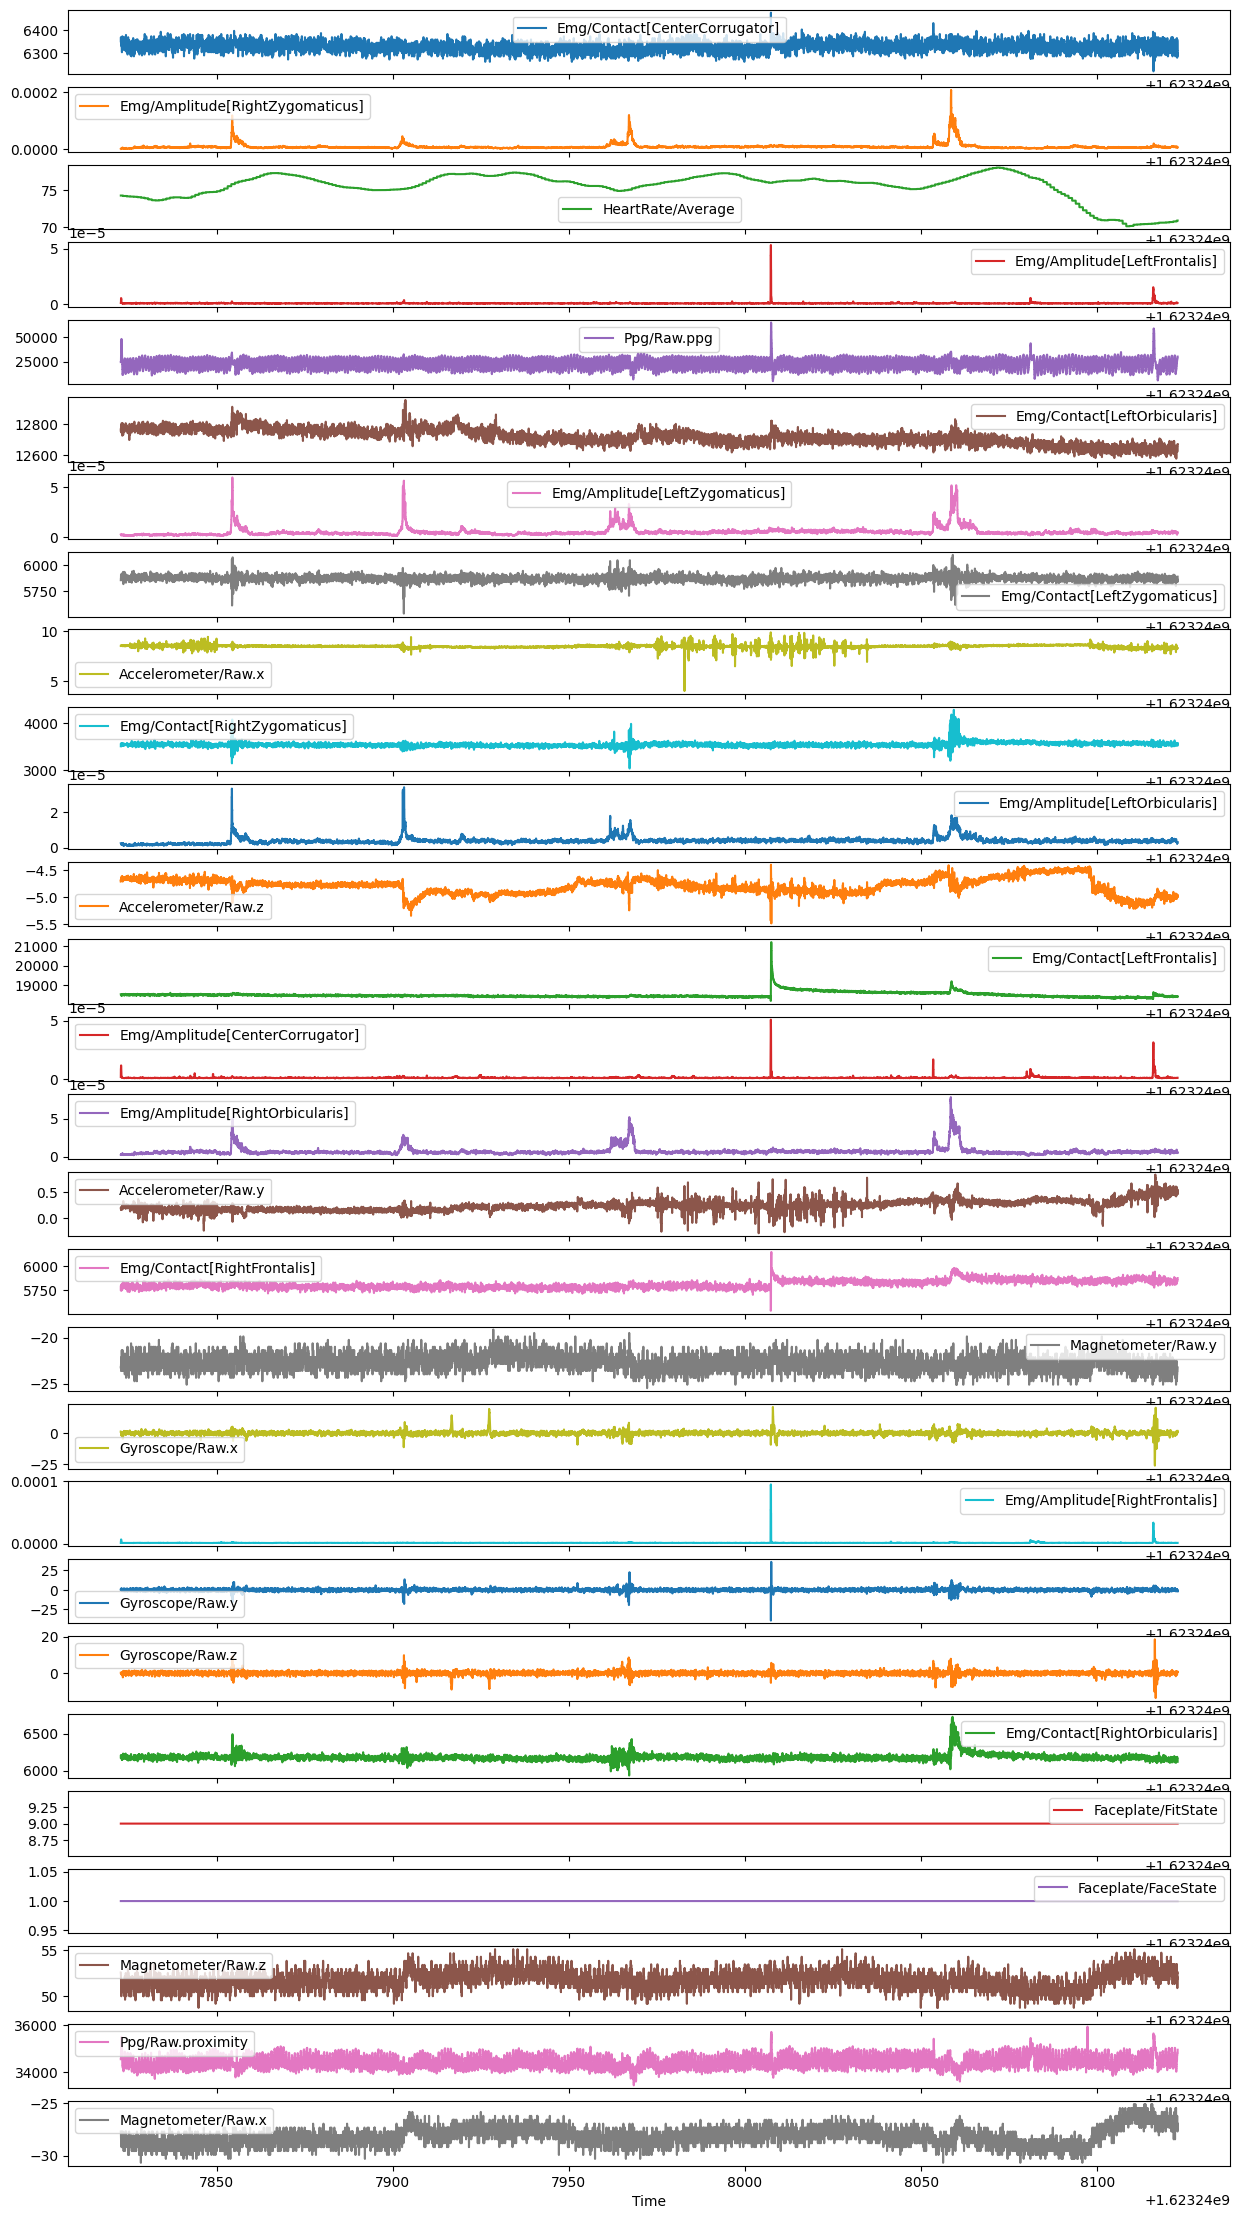

In [32]:
data_video.plot.line(subplots=True, figsize=(15,1*data.shape[1]), sharex=True)

## 2. Resample data to 50Hz

In order to extract features from the time series, it is common to resample the dataframes to the same sampling frequency. The function `avdosvr.analysis.dataframe_functions.resample_dataframe()` allows this process to obtain useful data from the combine dataset.

In [33]:
# Define sampling frequency
FS = 50

In [34]:
# Apply resampling dataframe at the defined sampling frequency.
data_rest_resampled = resample_dataframe(data_rest, FS, keep_original_timestamps=True)
data_video_resampled = resample_dataframe(data_video, FS, keep_original_timestamps=True)
data_video_resampled.head()

,Emg/Contact[CenterCorrugator],Emg/Amplitude[RightZygomaticus],HeartRate/Average,Emg/Amplitude[LeftFrontalis],Ppg/Raw.ppg,Emg/Contact[LeftOrbicularis],Emg/Amplitude[LeftZygomaticus],Emg/Contact[LeftZygomaticus],Accelerometer/Raw.x,Emg/Contact[RightZygomaticus],...,Gyroscope/Raw.x,Emg/Amplitude[RightFrontalis],Gyroscope/Raw.y,Gyroscope/Raw.z,Emg/Contact[RightOrbicularis],Faceplate/FitState,Faceplate/FaceState,Magnetometer/Raw.z,Ppg/Raw.proximity,Magnetometer/Raw.x
Time,,,,,,,,,,,,,,,,,,,,,
1.623248e+09,6352.0,0.000001,74.28,0.000001,24544,12764.0,0.000003,5858.0,8.50,3506.0,...,1.1875,0.000001,0.1250,0.1875,6178.0,9,1,52.5625,34544,-27.6875
1.623248e+09,6370.0,0.000002,74.28,0.000001,24544,12750.0,0.000003,5876.0,8.48,3566.0,...,0.4375,0.000002,1.0000,0.0625,6210.0,9,1,52.5625,34544,-27.6875
1.623248e+09,6370.0,0.000002,74.28,0.000003,24544,12750.0,0.000003,5876.0,8.49,3566.0,...,0.6875,0.000003,0.2500,0.0625,6210.0,9,1,51.6875,34544,-28.4375
1.623248e+09,6352.0,0.000002,74.28,0.000004,29984,12780.0,0.000003,5910.0,8.53,3528.0,...,0.6250,0.000006,0.1875,-0.5625,6178.0,9,1,51.6875,34816,-28.4375
1.623248e+09,6352.0,0.000002,74.28,0.000005,29984,12780.0,0.000002,5910.0,8.54,3528.0,...,-0.4375,0.000006,-0.0625,-0.5625,6178.0,9,1,51.2500,34816,-28.0625


In [35]:
# Check if there are missing values
data_video_resampled.isnull().sum()

Emg/Contact[CenterCorrugator]      0
Emg/Amplitude[RightZygomaticus]    0
HeartRate/Average                  0
Emg/Amplitude[LeftFrontalis]       0
Ppg/Raw.ppg                        0
Emg/Contact[LeftOrbicularis]       0
Emg/Amplitude[LeftZygomaticus]     0
Emg/Contact[LeftZygomaticus]       0
Accelerometer/Raw.x                0
Emg/Contact[RightZygomaticus]      0
Emg/Amplitude[LeftOrbicularis]     0
Accelerometer/Raw.z                0
Emg/Contact[LeftFrontalis]         0
Emg/Amplitude[CenterCorrugator]    0
Emg/Amplitude[RightOrbicularis]    0
Accelerometer/Raw.y                0
Emg/Contact[RightFrontalis]        0
Magnetometer/Raw.y                 0
Gyroscope/Raw.x                    0
Emg/Amplitude[RightFrontalis]      0
Gyroscope/Raw.y                    0
Gyroscope/Raw.z                    0
Emg/Contact[RightOrbicularis]      0
Faceplate/FitState                 0
Faceplate/FaceState                0
Magnetometer/Raw.z                 0
Ppg/Raw.proximity                  0
M

array([<AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>], dtype=object)

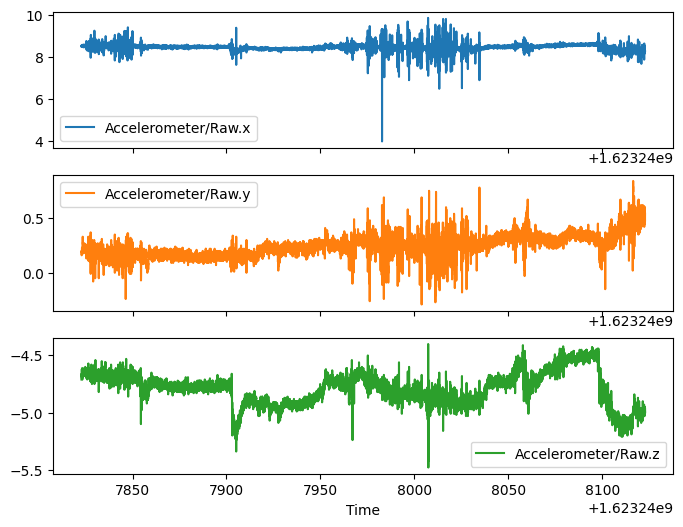

In [36]:
# Subset of columns sub
df_plot = data_video_resampled[ avdosvr.preprocessing.COLNAMES_ACCELEROMETER ]
df_plot.plot.line(subplots=True, figsize=(8,2*df_plot.shape[1]), sharex=True)

array([<AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>,
       <AxesSubplot: xlabel='Time'>, <AxesSubplot: xlabel='Time'>],
      dtype=object)

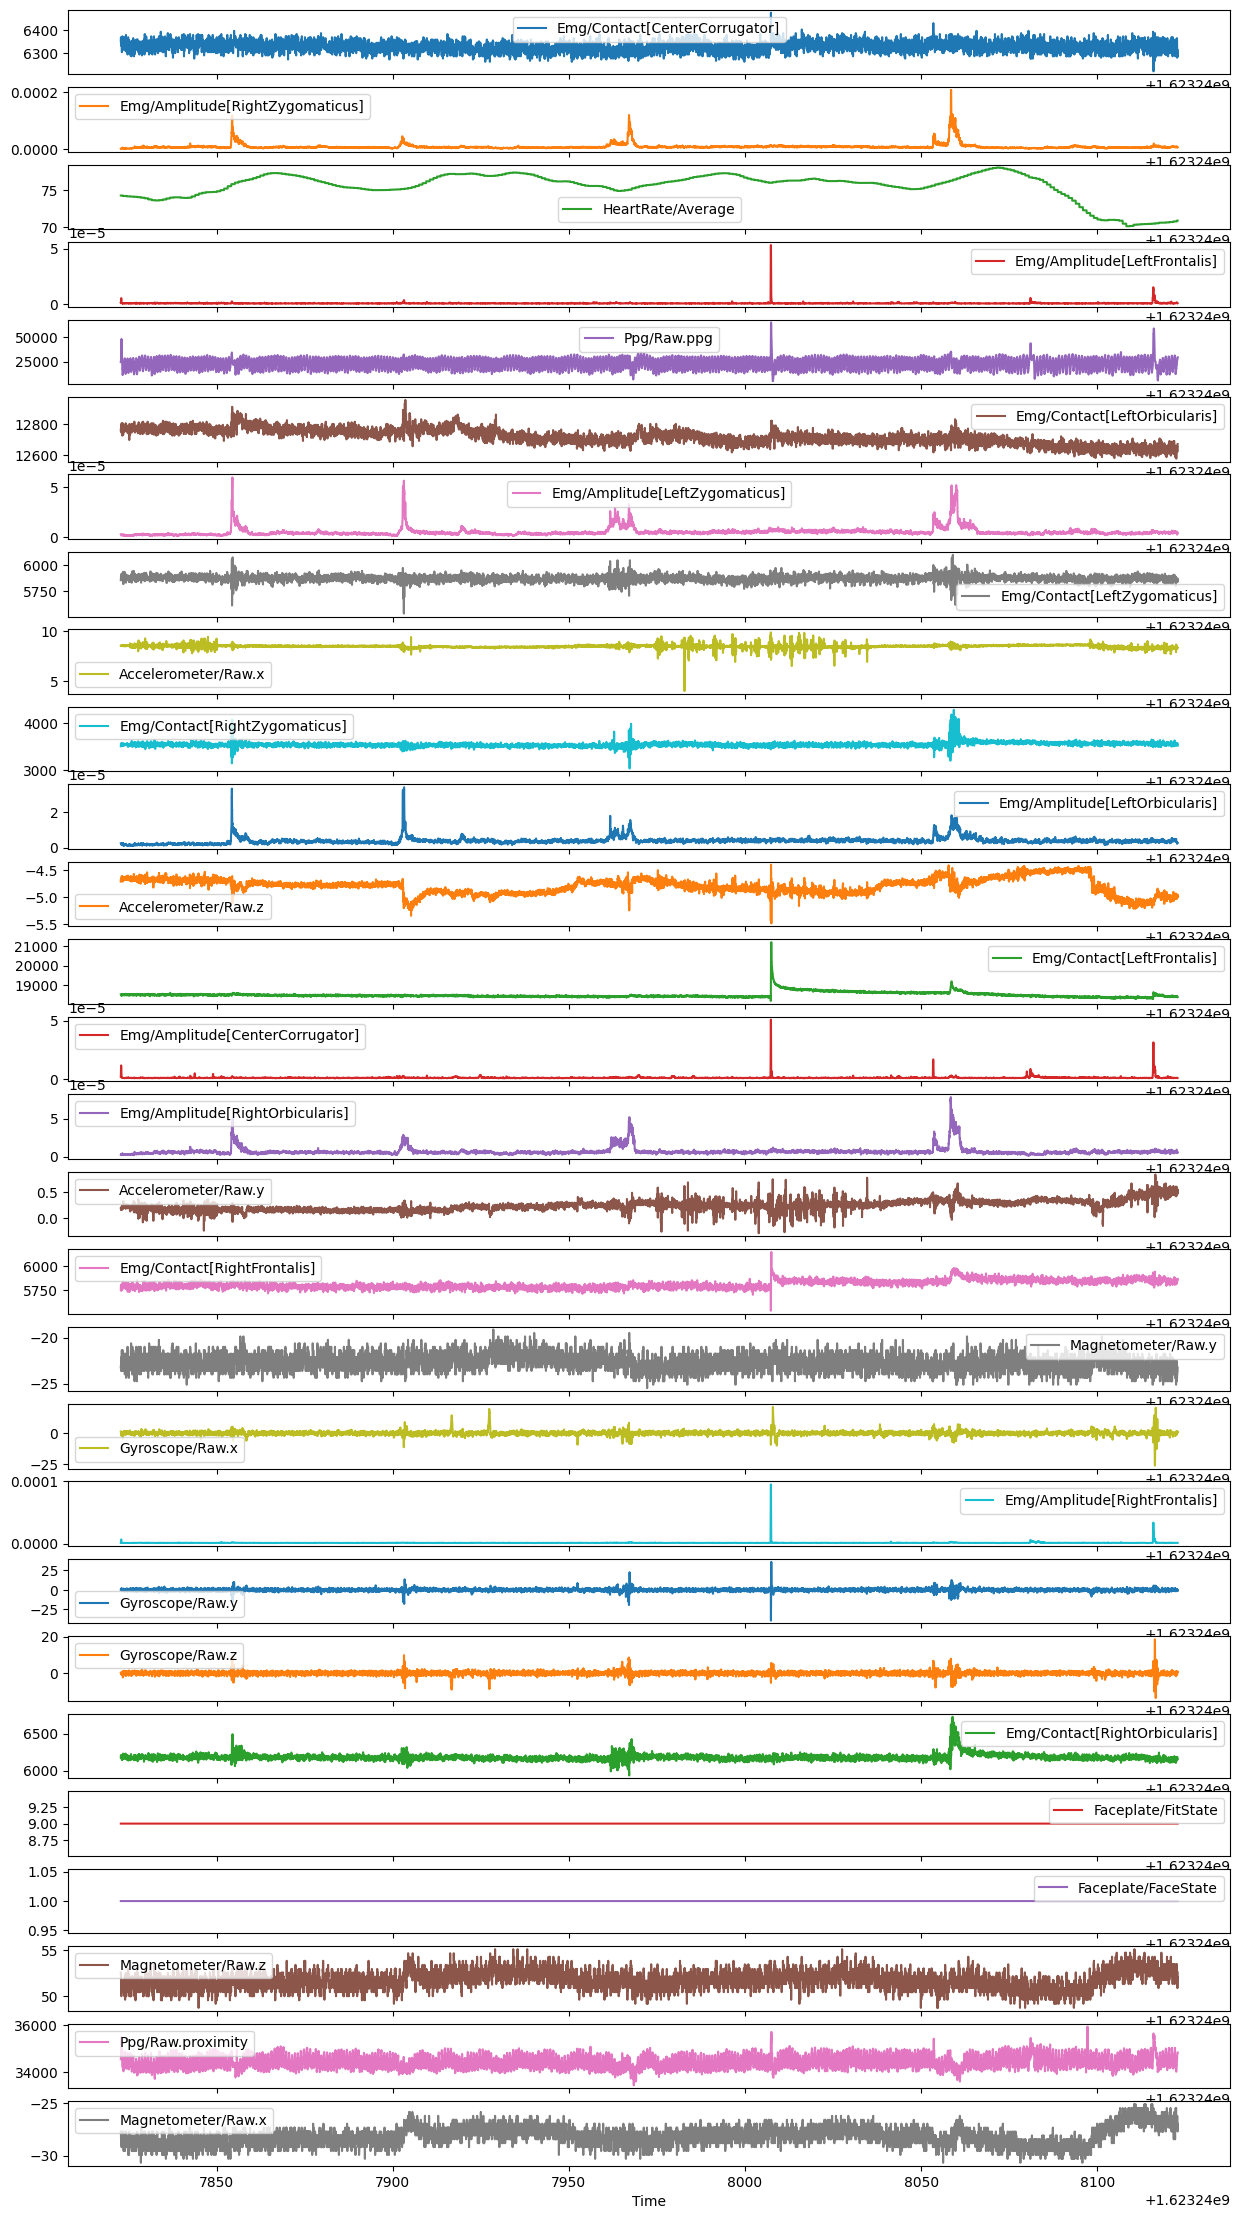

In [37]:
data_video_resampled.plot.line(subplots=True, figsize=(15,1*data_video_resampled.shape[1]), sharex=True)

In [38]:
## Uncomment thes lines to save the image in a file
path_to_save = gen_path_temp(f"example_figure", extension=".png")
data_video_resampled.plot.line(subplots=True, figsize=(15,1*data_video_resampled.shape[1]), sharex=True)[0].figure.savefig(path_to_save)
print(path_to_save)
plt.close()

e:\dsv\dev\git_repos\AVDOS-VR\notebooks/temp/1_preprocess/example_figure.png


## 3. Find affect states and Video IDs

Load the subjective affective ratings corresponding to the file of a specific `affect segment`. The function `load_emotions_from_affect_segment()` obtains the individual rest and video affect ratings for a given affect stage. The returned values are:

- `Valence`: Affective valence rating. Range 1-9
- `Arousal`: Affective arousal rating. Range 1-9
- `RawX`: Raw input x-axis from joystick used to report valence. Range 0-255
- `RawY`: Raw input y-axis from joystick used to report arousal. Range 0-255

In [39]:
emotions_rest, emotions_video = data_loader.load_emotions_from_affect_segment(PARTICIPANT_IDX, AFFECTIVE_SEGMENT)
emotions_video

,Valence,Arousal,RawX,RawY
Time,,,,
1.623248e+09,6,1,166,30
1.623248e+09,6,2,165,56
1.623248e+09,6,3,151,74
1.623248e+09,5,3,147,80
1.623248e+09,5,4,145,95
...,...,...,...,...
1.623248e+09,8,9,177,186
1.623248e+09,8,8,181,177
1.623248e+09,7,8,175,169


The function `calculate_video_id_end_timestamps()` provides the end time of each video within the video stage, given a user and a specific affect segment. The possible values of the column `VideoId` are:
- `NaN`: Last timestamp of data not corresponding to a experimental segments (e.g., measuring from Emteq mask without having started the experiment)
- `-1`: Last timestamp of the `resting video` from the specific affect segment.
- `[int]`: Integer denoting the last timestamp of the user watching the corresponding `VideoId`

In [40]:
# Find the corresponding ending of the videoID. `VideoId=-1` corresponding to a resting stage
video_id_end_timestamp = data_loader.calculate_video_id_end_timestamps(PARTICIPANT_IDX, AFFECTIVE_SEGMENT)
video_id_end_timestamp

,VideoId
Time,
1.623248e+09,NaN
1.623248e+09,-1.0
1.623248e+09,51.0
1.623248e+09,49.0
1.623248e+09,46.0
1.623248e+09,41.0
1.623248e+09,48.0
1.623248e+09,57.0
1.623248e+09,56.0


## 4. Merging the physiological data, affect ratings, and video ids.

The sampling frequency of the physiological `data` does not match the frequency and timestamps of the `emotions`. Thus, they need to be merged.

The `VideoId` corresponding to each physiological data sample can be loaded using the function `merge_asof()`

In [41]:
# Merge the the physiological data with the emotions
data_rest_merged = pd.merge_asof(data_rest_resampled, video_id_end_timestamp, left_index=True, right_index=True, direction="forward")
data_rest_merged.insert(0, "OriginalParticipantID", data_loader.index[PARTICIPANT_IDX]['participant_id'])
data_rest_merged = pd.merge_asof(data_rest_merged, emotions_rest, left_index=True, right_index=True)
data_rest_merged

,OriginalParticipantID,Emg/Contact[CenterCorrugator],Emg/Amplitude[RightZygomaticus],HeartRate/Average,Emg/Amplitude[LeftFrontalis],Ppg/Raw.ppg,Emg/Contact[LeftOrbicularis],Emg/Amplitude[LeftZygomaticus],Emg/Contact[LeftZygomaticus],Accelerometer/Raw.x,...,Faceplate/FitState,Faceplate/FaceState,Magnetometer/Raw.z,Ppg/Raw.proximity,Magnetometer/Raw.x,VideoId,Valence,Arousal,RawX,RawY
Time,,,,,,,,,,,,,,,,,,,,,
1.623248e+09,101,6356.0,0.000001,79.25,9.536743e-07,24480,12844.0,8.344650e-07,5886.0,8.61,...,1,1,49.1250,34224,-29.1875,-1.0,NaN,NaN,NaN,NaN
1.623248e+09,101,6332.0,0.000001,79.25,8.742015e-07,26064,12824.0,8.742015e-07,5892.0,8.61,...,1,1,49.1250,34336,-29.1875,-1.0,NaN,NaN,NaN,NaN
1.623248e+09,101,6332.0,0.000001,79.25,1.271566e-06,26064,12824.0,9.536743e-07,5892.0,8.58,...,1,1,49.5625,34336,-29.5625,-1.0,NaN,NaN,NaN,NaN
1.623248e+09,101,6352.0,0.000001,79.25,1.311302e-06,27056,12860.0,9.934107e-07,5876.0,8.56,...,1,1,49.5625,34336,-29.5625,-1.0,NaN,NaN,NaN,NaN
1.623248e+09,101,6352.0,0.000002,79.25,1.351039e-06,27056,12860.0,1.033147e-06,5876.0,8.65,...,1,1,49.1250,34336,-29.5625,-1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.623248e+09,101,6294.0,0.000002,74.28,1.231829e-06,19712,12754.0,2.066294e-06,5886.0,8.55,...,9,1,50.8125,34272,-29.1875,-1.0,7.0,1.0,181.0,43.0
1.623248e+09,101,6294.0,0.000002,74.28,1.231829e-06,19712,12754.0,2.264977e-06,5886.0,8.52,...,9,1,50.8125,34272,-29.1875,-1.0,7.0,1.0,181.0,43.0
1.623248e+09,101,6324.0,0.000002,74.28,1.152356e-06,20992,12760.0,2.185504e-06,5882.0,8.54,...,9,1,50.4375,34240,-28.4375,-1.0,7.0,1.0,181.0,43.0


In [42]:
# Merge physio with affective ratings
data_video_merged = pd.merge_asof(data_video_resampled, video_id_end_timestamp, left_index=True, right_index=True, direction="forward")
data_video_merged.insert(0, "OriginalParticipantID", data_loader.index[PARTICIPANT_IDX]['participant_id'])
data_video_merged = pd.merge_asof(data_video_merged, emotions_video, left_index=True, right_index=True)
data_video_merged

,OriginalParticipantID,Emg/Contact[CenterCorrugator],Emg/Amplitude[RightZygomaticus],HeartRate/Average,Emg/Amplitude[LeftFrontalis],Ppg/Raw.ppg,Emg/Contact[LeftOrbicularis],Emg/Amplitude[LeftZygomaticus],Emg/Contact[LeftZygomaticus],Accelerometer/Raw.x,...,Faceplate/FitState,Faceplate/FaceState,Magnetometer/Raw.z,Ppg/Raw.proximity,Magnetometer/Raw.x,VideoId,Valence,Arousal,RawX,RawY
Time,,,,,,,,,,,,,,,,,,,,,
1.623248e+09,101,6352.0,0.000001,74.28,0.000001,24544,12764.0,0.000003,5858.0,8.50,...,9,1,52.5625,34544,-27.6875,51.0,NaN,NaN,NaN,NaN
1.623248e+09,101,6370.0,0.000002,74.28,0.000001,24544,12750.0,0.000003,5876.0,8.48,...,9,1,52.5625,34544,-27.6875,51.0,NaN,NaN,NaN,NaN
1.623248e+09,101,6370.0,0.000002,74.28,0.000003,24544,12750.0,0.000003,5876.0,8.49,...,9,1,51.6875,34544,-28.4375,51.0,NaN,NaN,NaN,NaN
1.623248e+09,101,6352.0,0.000002,74.28,0.000004,29984,12780.0,0.000003,5910.0,8.53,...,9,1,51.6875,34816,-28.4375,51.0,NaN,NaN,NaN,NaN
1.623248e+09,101,6352.0,0.000002,74.28,0.000005,29984,12780.0,0.000002,5910.0,8.54,...,9,1,51.2500,34816,-28.0625,51.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.623248e+09,101,6304.0,0.000008,70.91,0.000001,27728,12620.0,0.000004,5868.0,8.34,...,9,1,50.8750,34736,-27.3125,55.0,6.0,7.0,157.0,163.0
1.623248e+09,101,6286.0,0.000007,70.91,0.000001,28672,12660.0,0.000004,5840.0,8.29,...,9,1,50.8750,34800,-27.3125,55.0,6.0,7.0,157.0,163.0
1.623248e+09,101,6286.0,0.000008,70.91,0.000001,28672,12660.0,0.000005,5840.0,8.31,...,9,1,51.7500,34800,-27.6875,55.0,6.0,7.0,157.0,163.0


In [43]:
data_compiled = data_loader.generate_merged_synchronized_dataframe(PARTICIPANT_IDX,
                                                                AFFECTIVE_SEGMENT, 
                                                                avdosvr.preprocessing.COLNAMES_RECOMMENDED,
                                                                sampling_frequency_hz=FS,
                                                                set_timestamps_to_zero=True)

Loading from:  ../data/../data/participant_101\video_2.csv

Analyzing participant 0 segment Positive
Last timestamp stage REST: 120.03999996185303 	SHORT?:False
Last timestamp stage VIDEO: 300.039999961853 	SHORT?:False
Total missing vals: REST=960 | VIDEO= 356


In [44]:
data_compiled.loc[0,"Positive"]

C:\Users\luva3178\AppData\Local\Temp\ipykernel_6824\1781171815.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  data_compiled.loc[0,"Positive"]


,OriginalParticipantID,Emg/Contact[CenterCorrugator],Emg/Amplitude[RightZygomaticus],HeartRate/Average,Emg/Amplitude[LeftFrontalis],Ppg/Raw.ppg,Emg/Contact[LeftOrbicularis],Emg/Amplitude[LeftZygomaticus],Emg/Contact[LeftZygomaticus],Accelerometer/Raw.x,...,Faceplate/FitState,Faceplate/FaceState,Magnetometer/Raw.z,Ppg/Raw.proximity,Magnetometer/Raw.x,VideoId,Valence,Arousal,RawX,RawY
Time,,,,,,,,,,,,,,,,,,,,,
0.00,101,6352.0,0.000001,74.28,0.000001,24544,12764.0,0.000003,5858.0,8.50,...,9,1,52.5625,34544,-27.6875,51.0,NaN,NaN,NaN,NaN
0.02,101,6370.0,0.000002,74.28,0.000001,24544,12750.0,0.000003,5876.0,8.48,...,9,1,52.5625,34544,-27.6875,51.0,NaN,NaN,NaN,NaN
0.04,101,6370.0,0.000002,74.28,0.000003,24544,12750.0,0.000003,5876.0,8.49,...,9,1,51.6875,34544,-28.4375,51.0,NaN,NaN,NaN,NaN
0.06,101,6352.0,0.000002,74.28,0.000004,29984,12780.0,0.000003,5910.0,8.53,...,9,1,51.6875,34816,-28.4375,51.0,NaN,NaN,NaN,NaN
0.08,101,6352.0,0.000002,74.28,0.000005,29984,12780.0,0.000002,5910.0,8.54,...,9,1,51.2500,34816,-28.0625,51.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299.96,101,6304.0,0.000008,70.91,0.000001,27728,12620.0,0.000004,5868.0,8.34,...,9,1,50.8750,34736,-27.3125,55.0,6.0,7.0,157.0,163.0
299.98,101,6286.0,0.000007,70.91,0.000001,28672,12660.0,0.000004,5840.0,8.29,...,9,1,50.8750,34800,-27.3125,55.0,6.0,7.0,157.0,163.0
300.00,101,6286.0,0.000008,70.91,0.000001,28672,12660.0,0.000005,5840.0,8.31,...,9,1,51.7500,34800,-27.6875,55.0,6.0,7.0,157.0,163.0


## 5. Merging all participants' data

Finally, we store the postprocessed dataframes from all participants in a single CSV file. This file can be handled directly in Python because the size is much smaller than the original dataset. The sampling frequency was reduced from ~1KHz to 50Hz.

In this case, we combine the raw dataset keeping two columns `["Participant","AffectSegment"]` to identify the individual files. However, you may involve feature extraction to a more comprehensive dataset.

In [45]:
# Total participants
participants_ids = data_loader.summary["index_id"].unique()
participants_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38], dtype=int64)

In [46]:
# Total sessions
affect_segments = [ str(x) for x in avdosEnums.AffectSegments]
affect_segments

['Positive', 'Negative', 'Neutral']

In [47]:
# Columns to process per participant
data_columns_to_analyze = avdosvr.preprocessing.COLNAMES_RECOMMENDED
data_columns_to_analyze

['Emg/Amplitude[RightFrontalis]',
 'Emg/Amplitude[RightZygomaticus]',
 'Emg/Amplitude[RightOrbicularis]',
 'Emg/Amplitude[CenterCorrugator]',
 'Emg/Amplitude[LeftOrbicularis]',
 'Emg/Amplitude[LeftZygomaticus]',
 'Emg/Amplitude[LeftFrontalis]',
 'Emg/Contact[RightFrontalis]',
 'Emg/Contact[RightZygomaticus]',
 'Emg/Contact[RightOrbicularis]',
 'Emg/Contact[CenterCorrugator]',
 'Emg/Contact[LeftOrbicularis]',
 'Emg/Contact[LeftZygomaticus]',
 'Emg/Contact[LeftFrontalis]',
 'Faceplate/FaceState',
 'Faceplate/FitState',
 'HeartRate/Average',
 'Ppg/Raw.ppg',
 'Ppg/Raw.proximity',
 'Accelerometer/Raw.x',
 'Accelerometer/Raw.y',
 'Accelerometer/Raw.z',
 'Magnetometer/Raw.x',
 'Magnetometer/Raw.y',
 'Magnetometer/Raw.z',
 'Gyroscope/Raw.x',
 'Gyroscope/Raw.y',
 'Gyroscope/Raw.z']

In [48]:
# Define sampling frequency for resampling
SAMPLING_FREQ_HZ = 50

The same process shown above is incorporated in the function `generate_merged_synchronized_dataframe()`.

⛔⛔ **NOTE: The execution of the next cell may take between 30-60min because it goes through the whole dataset to generate a postprocessed version** ⛔⛔

In [49]:
# Loading all segments for all participants and store the resting and video parts in a single large CSV.

DATASET_POSTPROCESSED_FILENAME = gen_path_temp("Dataset_AVDOSVR_postprocessed", extension=".csv")

output_filename = DATASET_POSTPROCESSED_FILENAME

# Variable to store the final dataset
dataset_postprocessed_final = None
# Check if file already exists
if (os.path.isfile(output_filename)):
    dataset_postprocessed_final = pd.read_csv(output_filename)
    print(f"File loaded from path!")
# Otherwise generate it
else:
    print(f"Generating file!")
    for participant in participants_ids:
        for aff_segment in affect_segments:
            print(f"\n\nAnalyzing participant {participant} segment {aff_segment}")

            # Final concatenation of resting and video stages
            data_compiled = data_loader.generate_merged_synchronized_dataframe(participant,
                                                                                 aff_segment, 
                                                                                 data_columns_to_analyze,
                                                                                 sampling_frequency_hz=SAMPLING_FREQ_HZ,
                                                                                 set_timestamps_to_zero=True)

            # Generate final DF
            if(dataset_postprocessed_final is None):
                dataset_postprocessed_final = data_compiled.copy(deep=True)
            else:
                dataset_postprocessed_final = pd.concat([dataset_postprocessed_final, data_compiled.copy(deep=True)])

        # Saving .csv every iteration
        dataset_postprocessed_final.to_csv( output_filename )
    print("\n\n End")

File loaded from path!


In [50]:
dataset_postprocessed_final.head()

,Participant,Stage,Time,OriginalParticipantID,Gyroscope/Raw.y,Magnetometer/Raw.y,Emg/Contact[RightFrontalis],Magnetometer/Raw.x,Emg/Contact[CenterCorrugator],Emg/Amplitude[LeftFrontalis],...,Gyroscope/Raw.x,Emg/Amplitude[RightOrbicularis],Emg/Contact[LeftOrbicularis],Accelerometer/Raw.z,Emg/Amplitude[LeftZygomaticus],VideoId,Valence,Arousal,RawX,RawY
0,0,Resting_Positive,0.00,101,-1.0000,-23.625,5764.0,-29.1875,6356.0,9.536743e-07,...,-1.3125,0.000002,12844.0,-4.50,8.344650e-07,-1.0,NaN,NaN,NaN,NaN
1,0,Resting_Positive,0.02,101,-1.0000,-23.625,5756.0,-29.1875,6332.0,8.742015e-07,...,-1.3125,0.000002,12824.0,-4.50,8.742015e-07,-1.0,NaN,NaN,NaN,NaN
2,0,Resting_Positive,0.04,101,-0.5625,-23.250,5756.0,-29.5625,6332.0,1.271566e-06,...,-1.0625,0.000002,12824.0,-4.49,9.536743e-07,-1.0,NaN,NaN,NaN,NaN
3,0,Resting_Positive,0.06,101,0.3750,-23.250,5792.0,-29.5625,6352.0,1.311302e-06,...,-0.8750,0.000002,12860.0,-4.50,9.934107e-07,-1.0,NaN,NaN,NaN,NaN
4,0,Resting_Positive,0.08,101,0.7500,-23.625,5792.0,-29.5625,6352.0,1.351039e-06,...,-0.3125,0.000002,12860.0,-4.45,1.033147e-06,-1.0,NaN,NaN,NaN,NaN


In [51]:
dataset_postprocessed_final.shape

(2452420, 37)

In [52]:
print(">> FINISHED WITHOUT ERRORS!!")

>> FINISHED WITHOUT ERRORS!!
